In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import statsmodels.formula.api as smf
import statsmodels.api as sm 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist, squareform

sns.set(font_scale=1.5, style='whitegrid')
plt.rcParams["font.family"] = "sans serif"
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

COLORS = ['#0059ff', '#fdbd28']
GREY = '#788995'
DGREY = '#060F41'
FONTCOL = '#000000'
LINEWIDTH=5
FS_SUPTITLE = 30
FS_CAPTION = 24
FS_LABEL = 24
FS_FOOTNOTE = 20
RDATA = os.path.join('data', 'raw')
PDATA = os.path.join('data', 'processed')

In [2]:
# Bring in state series and construct YoY percent change
df_state = pd.read_csv(os.path.join(PDATA, 'df_state_series.csv'), parse_dates=['year_month'])
df_state = df_state.sort_values('year_month')

# Compute drinks instead
df_state['n_drinks'] = df_state['n_liters'] * (33.814 / 1.5)
df_state['n_drinks_yoy_perc'] = 100 * df_state['n_drinks'].pct_change(12)
df_state['year'] = df_state['year_month'].dt.year
df_state['month'] = df_state['year_month'].dt.month
df_state['n_drinks_yoy_perc_smooth'] = df_state['n_drinks_yoy_perc'].rolling(window=3, center=True).mean()
df_state.tail()

,year_month,n_liters,n_transactions,n_bottles,bottles_p_transaction,employment,unemployment,unemployment_rate,emp_population,cases,deaths,time_index,time_cycle,pop_total,pop_gt18,pop_gt21,n_drinks,n_drinks_yoy_perc,year,month,n_drinks_yoy_perc_smooth
107,2020-12-01,2.360986e+06,253889,2912674,11.472234,1559562.0,59879.0,3.7,2.483379e+06,51078.0,1465.0,107,-1.133108e-15,3155070,2433240,2294466,5.322292e+07,15.671159,2020,12,9.734743
108,2021-01-01,1.724365e+06,196467,2203381,11.215018,1567143.0,58010.0,3.6,2.483586e+06,36043.0,986.0,108,0.000000e+00,3155070,2433240,2294466,3.887178e+07,10.046051,2021,1,11.487108
109,2021-02-01,1.773047e+06,190006,2225257,11.711509,1570232.0,60695.0,3.7,2.480619e+06,18700.0,593.0,109,5.406408e-01,3155070,2433240,2294466,3.996921e+07,8.744115,2021,2,9.142930
110,2021-03-01,2.125044e+06,229986,2680901,11.656801,1573432.0,60875.0,3.7,2.481754e+06,14947.0,273.0,110,9.096320e-01,3155070,2433240,2294466,4.790416e+07,8.638623,2021,3,5.767062
111,2021-04-01,2.034895e+06,224667,2643103,11.764536,NaN,NaN,NaN,NaN,13439.0,207.0,111,9.898214e-01,3155070,2433240,2294466,4.587195e+07,-0.081553,2021,4,NaN


In [3]:
# Load in county-level dataset
df = pd.read_csv(os.path.join(PDATA, 'df_county_series.csv'), parse_dates=['year_month'])
df['year_month'] = df['year_month'].apply(lambda x: pd.Period(x, freq='M'))
df['n_drinks'] = df['n_liters'] * (33.814 / 1.5)
df.head()

,year_month,fips,n_liters,n_transactions,n_bottles,bottles_p_transaction,employment,unemployment,unemployment_rate,cases,deaths,pop_total,median_age,pop_gt18,pop_gt21,perc_gt21,perc_race_white,perc_race_black,perc_race_asian,perc_race_multi,median_income,perc_snap,perc_health_insurance,perc_poverty,perc_ed_gt_hs,perc_ed_gt_bach,perc_ed_gt_grad,county,county_num,area_sq_mi,lat,long,n_drinks
0,2012-01,19001,2165.94,319,2263,7.094044,3820.0,210.0,5.1,NaN,NaN,7085,45.4,5566,5397,76.2,97.5,0.6,0.7,1.0,53363,11.7,95.6,5.8,94.2,18.5,4.2,adair,1,569.271,41.328528,-94.478164,48826.063440
1,2012-01,19003,701.04,169,686,4.059172,2110.0,110.0,4.9,NaN,NaN,3670,47.3,2903,2813,76.6,98.6,0.1,0.2,0.2,49255,10.4,94.2,7.1,93.8,15.6,3.6,adams,2,423.433,41.021656,-94.696906,15803.311040
2,2012-01,19005,4177.72,678,3933,5.800885,7010.0,690.0,8.9,NaN,NaN,13813,44.4,10619,10254,74.2,96.5,1.3,0.6,1.0,52216,9.4,92.4,7.4,88.3,17.8,4.7,allamakee,3,639.044,43.274964,-91.382751,94176.949387
3,2012-01,19007,3395.90,620,3571,5.759677,5520.0,460.0,7.6,NaN,NaN,12452,45.7,9719,9308,74.8,97.0,0.7,0.5,1.5,40167,14.4,92.2,11.4,90.2,16.3,4.8,appanoose,4,497.289,40.744249,-92.873065,76552.641733
4,2012-01,19009,1245.01,199,1188,5.969849,3070.0,210.0,6.5,NaN,NaN,5571,48.1,4425,4262,76.5,96.9,0.2,0.3,2.5,52055,8.3,94.8,8.6,89.5,17.1,5.1,audubon,5,442.961,41.679178,-94.904312,28065.845427


In [4]:
# Define 3, 6, and 12 month pandemic windows and baseline windows from prior year
window_config = {
    3: [
        ['2019-04', '2019-06'],
        ['2020-04', '2020-06']
    ],
    6: [
        ['2019-04', '2019-09'],
        ['2020-04', '2020-09']
    ],
    12: [
        ['2019-04', '2020-03'],
        ['2020-04', '2021-03']
    ]
}
agg_dfs = []
for window_size, windows in window_config.items():
    windows = [[pd.Period(bound, freq='M') for bound in window] for window in windows]
    # binary label for before vs. during COVID
    for window, label in zip(windows, [0, 1]):
        df_temp = df.loc[(df['year_month'] >= window[0]) & (df['year_month'] <= window[1])].copy()
        print(f'window size: {window_size}, label: {label}, rows: {df_temp.shape[0]}')
        df_temp = df_temp.groupby('fips', as_index=False).agg({
        'n_drinks': np.sum,
        'n_transactions': np.sum,
        'n_bottles': np.sum,
        'unemployment_rate': np.mean,
        'cases': np.sum,
        'deaths': np.sum,
        'pop_total': np.mean,
        'median_age': np.mean,
        'pop_gt18': np.mean,
        'perc_race_white': np.mean,
        'perc_race_black': np.mean,
        'perc_race_asian': np.mean,
        'perc_race_multi': np.mean,
        'median_income': np.mean,
        'perc_snap': np.mean,
        'perc_health_insurance': np.mean,
        'perc_poverty': np.mean,
        'perc_ed_gt_hs': np.mean,
        'perc_ed_gt_bach': np.mean,
        'perc_ed_gt_grad': np.mean,
        'area_sq_mi': np.mean,
        'lat': np.mean,
        'long': np.mean,
        'county': 'first'
        })
        df_temp['window_size'] = window_size
        df_temp['label'] = label
        agg_dfs.append(df_temp)
        
        # Basic feature construction
        df_temp['drinks_per_capita'] = df_temp['n_drinks'] / df_temp['pop_gt18']
        df_temp['drinks_per_capita_per_month'] = df_temp['drinks_per_capita'] / df_temp['window_size']
        df_temp['cases_per_capita'] = df_temp['cases'] / df_temp['pop_total']
        df_temp['deaths_per_capita'] = df_temp['deaths'] / df_temp['pop_total']
        df_temp['pop_density'] = df_temp['pop_total'] / df_temp['area_sq_mi']
        df_temp['log_pop_density'] = np.log(df_temp['pop_density'])
df_cs = pd.concat(agg_dfs)
df_cs.head()

window size: 3, label: 0, rows: 295
window size: 3, label: 1, rows: 297
window size: 6, label: 0, rows: 592
window size: 6, label: 1, rows: 593
window size: 12, label: 0, rows: 1185
window size: 12, label: 1, rows: 1187


,fips,n_drinks,n_transactions,n_bottles,unemployment_rate,cases,deaths,pop_total,median_age,pop_gt18,perc_race_white,perc_race_black,perc_race_asian,perc_race_multi,median_income,perc_snap,perc_health_insurance,perc_poverty,perc_ed_gt_hs,perc_ed_gt_bach,perc_ed_gt_grad,area_sq_mi,lat,long,county,window_size,label,drinks_per_capita,drinks_per_capita_per_month,cases_per_capita,deaths_per_capita,pop_density,log_pop_density
0,19001,226895.772253,1505,11262,2.200000,0.0,0.0,7085,45.4,5566,97.5,0.6,0.7,1.0,53363,11.7,95.6,5.8,94.2,18.5,4.2,569.271,41.328528,-94.478164,adair,3,0,40.764602,13.588201,0.0,0.0,12.445742,2.521379
1,19003,4598.253147,60,345,1.700000,0.0,0.0,3670,47.3,2903,98.6,0.1,0.2,0.2,49255,10.4,94.2,7.1,93.8,15.6,3.6,423.433,41.021656,-94.696906,adams,3,0,1.583966,0.527989,0.0,0.0,8.667251,2.159552
2,19005,409203.953253,2460,16777,3.133333,0.0,0.0,13813,44.4,10619,96.5,1.3,0.6,1.0,52216,9.4,92.4,7.4,88.3,17.8,4.7,639.044,43.274964,-91.382751,allamakee,3,0,38.535074,12.845025,0.0,0.0,21.615100,3.073392
3,19007,425412.130587,2265,20803,3.100000,0.0,0.0,12452,45.7,9719,97.0,0.7,0.5,1.5,40167,14.4,92.2,11.4,90.2,16.3,4.8,497.289,40.744249,-92.873065,appanoose,3,0,43.771183,14.590394,0.0,0.0,25.039766,3.220465
4,19009,83950.243227,694,3967,2.266667,0.0,0.0,5571,48.1,4425,96.9,0.2,0.3,2.5,52055,8.3,94.8,8.6,89.5,17.1,5.1,442.961,41.679178,-94.904312,audubon,3,0,18.971806,6.323935,0.0,0.0,12.576728,2.531848


In [5]:
# Make YoY dataset as well
df_csy = df_cs.sort_values(['fips', 'window_size', 'label']).copy()
df_csy['drinks_per_capita_per_month_diff'] = df_csy['drinks_per_capita_per_month'].diff()
df_csy['drinks_per_capita_per_month_perc'] = 100 * df_csy['drinks_per_capita_per_month'].pct_change()
df_csy['unemployment_rate_diff'] = df_csy['unemployment_rate'].diff()
df_csy['unemployment_rate_perc'] = df_csy['unemployment_rate'].pct_change()
df_csy = df_csy.loc[df_csy['label'] == 1]
df_csy.head()

,fips,n_drinks,n_transactions,n_bottles,unemployment_rate,cases,deaths,pop_total,median_age,pop_gt18,perc_race_white,perc_race_black,perc_race_asian,perc_race_multi,median_income,perc_snap,perc_health_insurance,perc_poverty,perc_ed_gt_hs,perc_ed_gt_bach,perc_ed_gt_grad,area_sq_mi,lat,long,county,window_size,label,drinks_per_capita,drinks_per_capita_per_month,cases_per_capita,deaths_per_capita,pop_density,log_pop_density,drinks_per_capita_per_month_diff,drinks_per_capita_per_month_perc,unemployment_rate_diff,unemployment_rate_perc
0,19001,178463.980053,1177,9318,6.900000,14.0,0.0,7085,45.4,5566,97.5,0.6,0.7,1.0,53363,11.7,95.6,5.8,94.2,18.5,4.2,569.271,41.328528,-94.478164,adair,3,1,32.063238,10.687746,0.001976,0.000000,12.445742,2.521379,-2.900455,-21.345392,4.700000,2.136364
0,19001,345348.017667,2417,18921,5.166667,75.0,1.0,7085,45.4,5566,97.5,0.6,0.7,1.0,53363,11.7,95.6,5.8,94.2,18.5,4.2,569.271,41.328528,-94.478164,adair,6,1,62.045997,10.340999,0.010586,0.000141,12.445742,2.521379,0.304160,3.030435,3.033333,1.421875
0,19001,695226.885907,4955,40059,4.191667,836.0,32.0,7085,45.4,5566,97.5,0.6,0.7,1.0,53363,11.7,95.6,5.8,94.2,18.5,4.2,569.271,41.328528,-94.478164,adair,12,1,124.906016,10.408835,0.117996,0.004517,12.445742,2.521379,1.218273,13.255701,1.883333,0.815884
1,19003,90848.524653,743,4368,6.166667,8.0,0.0,3670,47.3,2903,98.6,0.1,0.2,0.2,49255,10.4,94.2,7.1,93.8,15.6,3.6,423.433,41.021656,-94.696906,adams,3,1,31.294704,10.431568,0.002180,0.000000,8.667251,2.159552,9.903579,1875.718208,4.466667,2.627451
1,19003,176186.945293,1403,8554,5.033333,38.0,0.0,3670,47.3,2903,98.6,0.1,0.2,0.2,49255,10.4,94.2,7.1,93.8,15.6,3.6,423.433,41.021656,-94.696906,adams,6,1,60.691335,10.115222,0.010354,0.000000,8.667251,2.159552,6.834124,208.287709,3.433333,2.145833


In [6]:
# Drop outlier county
df_cs.sort_values('drinks_per_capita', ascending=False)
df_csf = df_cs.loc[(df_cs['window_size'] == 12) & (df_cs['fips'] != 19059)].copy()

In [7]:
# Run OLS on 12 month window pre and post pandemic
df_temp = df_csf.loc[df_csf['label'] == 0]
pre_mod = smf.ols('drinks_per_capita_per_month ~ unemployment_rate', data=df_temp).fit()
pre_modx = df_temp['unemployment_rate']
pre_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     drinks_per_capita_per_month   R-squared:                       0.008
Model:                                     OLS   Adj. R-squared:                 -0.002
Method:                          Least Squares   F-statistic:                    0.7883
Date:                         Tue, 25 May 2021   Prob (F-statistic):              0.377
Time:                                 00:24:44   Log-Likelihood:                -302.25
No. Observations:                           98   AIC:                             608.5
Df Residuals:                               96   BIC:                             613.7
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            10.3064      2.655      3.882      0.000       5.037      15.576
unemployment_rate     0.8407      0.947      0.888      0.377      -1.039       2.720
==============================================================================
Omnibus:                        1.178   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.555   Jarque-Bera (JB):                1.258
Skew:                           0.240   Prob(JB):                        0.533
Kurtosis:                       2.720   Cond. No.                         15.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# Run OLS on 12 month window pre and post pandemic
df_temp = df_csf.loc[df_csf['label'] == 1]
pan_mod = smf.ols('drinks_per_capita_per_month ~ unemployment_rate', data=df_temp).fit()
pan_modx = df_temp['unemployment_rate']
pan_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     drinks_per_capita_per_month   R-squared:                       0.097
Model:                                     OLS   Adj. R-squared:                  0.088
Method:                          Least Squares   F-statistic:                     10.37
Date:                         Tue, 25 May 2021   Prob (F-statistic):            0.00175
Time:                                 00:24:44   Log-Likelihood:                -304.90
No. Observations:                           98   AIC:                             613.8
Df Residuals:                               96   BIC:                             619.0
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.8083      2.687      2.162      0.033       0.475      11.141
unemployment_rate     1.7148      0.533      3.220      0.002       0.658       2.772
==============================================================================
Omnibus:                        1.296   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.523   Jarque-Bera (JB):                1.367
Skew:                           0.253   Prob(JB):                        0.505
Kurtosis:                       2.719   Cond. No.                         25.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
# Run OLS on 12 month window pre and post pandemic
df_temp = df_csf.loc[df_csf['label'] == 0]
pre_mod = smf.ols('drinks_per_capita_per_month ~ unemployment_rate + log_pop_density', data=df_temp).fit()
pre_modx = df_temp['unemployment_rate']
pre_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     drinks_per_capita_per_month   R-squared:                       0.391
Model:                                     OLS   Adj. R-squared:                  0.378
Method:                          Least Squares   F-statistic:                     30.53
Date:                         Tue, 25 May 2021   Prob (F-statistic):           5.77e-11
Time:                                 00:24:44   Log-Likelihood:                -278.33
No. Observations:                           98   AIC:                             562.7
Df Residuals:                               95   BIC:                             570.4
Df Model:                                    2                                         
Covariance Type:                     nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1023      2.487     -0.041      0.967      -5.039       4.834
unemployment_rate    -0.4750      0.765     -0.621      0.536      -1.993       1.043
log_pop_density       4.0241      0.520      7.732      0.000       2.991       5.057
==============================================================================
Omnibus:                        3.742   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                3.474
Skew:                           0.461   Prob(JB):                        0.176
Kurtosis:                       2.994   Cond. No.                         27.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# Run OLS on 12 month window pre and post pandemic
df_temp = df_csf.loc[df_csf['label'] == 1]
pan_mod = smf.ols('drinks_per_capita_per_month ~ unemployment_rate + log_pop_density', data=df_temp).fit()
pan_modx = df_temp['unemployment_rate']
pan_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     drinks_per_capita_per_month   R-squared:                       0.350
Model:                                     OLS   Adj. R-squared:                  0.336
Method:                          Least Squares   F-statistic:                     25.53
Date:                         Tue, 25 May 2021   Prob (F-statistic):           1.34e-09
Time:                                 00:24:44   Log-Likelihood:                -288.85
No. Observations:                           98   AIC:                             583.7
Df Residuals:                               95   BIC:                             591.5
Df Model:                                    2                                         
Covariance Type:                     nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2176      2.471      0.088      0.930      -4.688       5.123
unemployment_rate    -0.0025      0.535     -0.005      0.996      -1.065       1.060
log_pop_density       4.0380      0.666      6.068      0.000       2.717       5.359
==============================================================================
Omnibus:                        6.509   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                5.909
Skew:                           0.553   Prob(JB):                       0.0521
Kurtosis:                       3.475   Cond. No.                         33.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

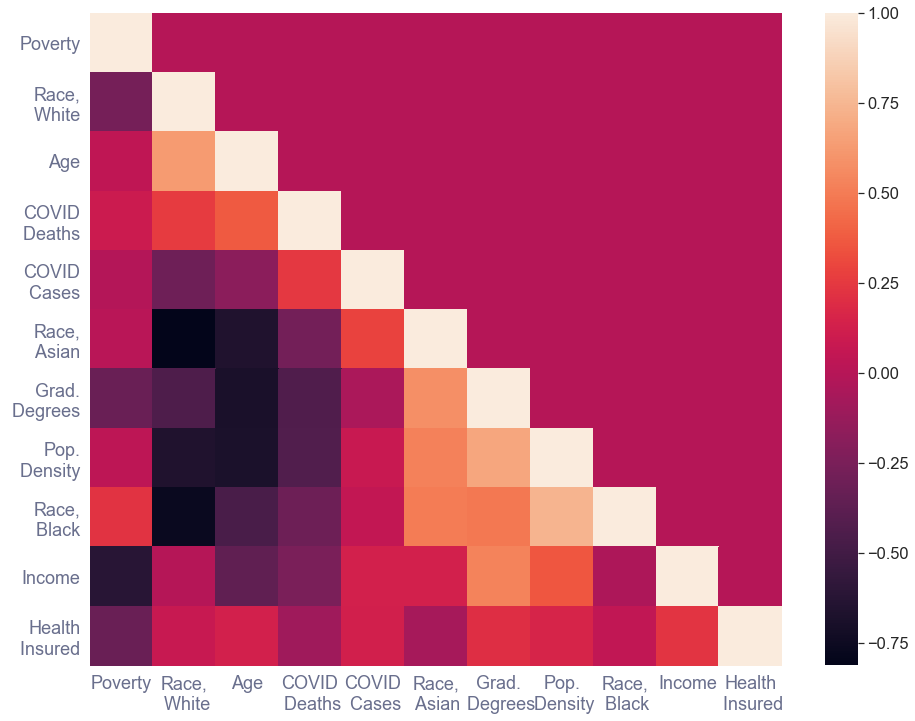

In [11]:
#plt.rcParams['figure.facecolor'] = (0.9176470588235294, 0.9176470588235294, 0.9490196078431372, 1.0)
# Make a heatmap for pairwise correlations
feats = ['median_age',
         'perc_race_white',
         'perc_race_black',
         'perc_race_asian',
         'median_income',
         'perc_health_insurance',
         'perc_poverty',
         'perc_ed_gt_bach',
         'cases_per_capita',
         'deaths_per_capita',
         'log_pop_density']

name_map = {
    'median_age': 'Age',
    'perc_race_white': 'Race,\n White',
    'perc_race_black': 'Race,\n Black',
    'perc_race_asian': 'Race,\n Asian',
    'median_income': 'Income',
    'perc_health_insurance': 'Health\n Insured',
    'perc_poverty': 'Poverty',
    'perc_ed_gt_bach': 'Grad.\n Degrees',
    'cases_per_capita': 'COVID\n Cases',
    'deaths_per_capita': 'COVID\n Deaths',
    'log_pop_density': 'Pop.\n Density'
}

df_temp = df_csf.loc[df_csf['label'] == 1][feats]
Z_dense = df_temp.corr().values * -1 + 1
Z_sparse = squareform(Z_dense)
Z = linkage(Z_sparse, optimal_ordering=True)
feats = [feats[i] for i in leaves_list(Z)]
df_corr = df_temp[feats].corr()
# Mask upper values
for i in range(df_corr.shape[0]):
    for j in range(df_corr.shape[1]):
        if j > i:
            df_corr.iloc[i, j] = 0
min_c = df_corr.min().min()
max_c = df_corr.max().min()
fig, ax = plt.subplots(figsize=(15.5, 12))
sns.heatmap(df_corr.rename(columns=name_map, index=name_map),
            ax=ax)
ax.tick_params(colors=DGREY, labelsize=FS_FOOTNOTE - 2, which='both')
plt.setp(ax.get_xticklabels(), alpha=0.6)
plt.setp(ax.get_yticklabels(), alpha=0.6)
plt.xticks(rotation=0)
plt.show()

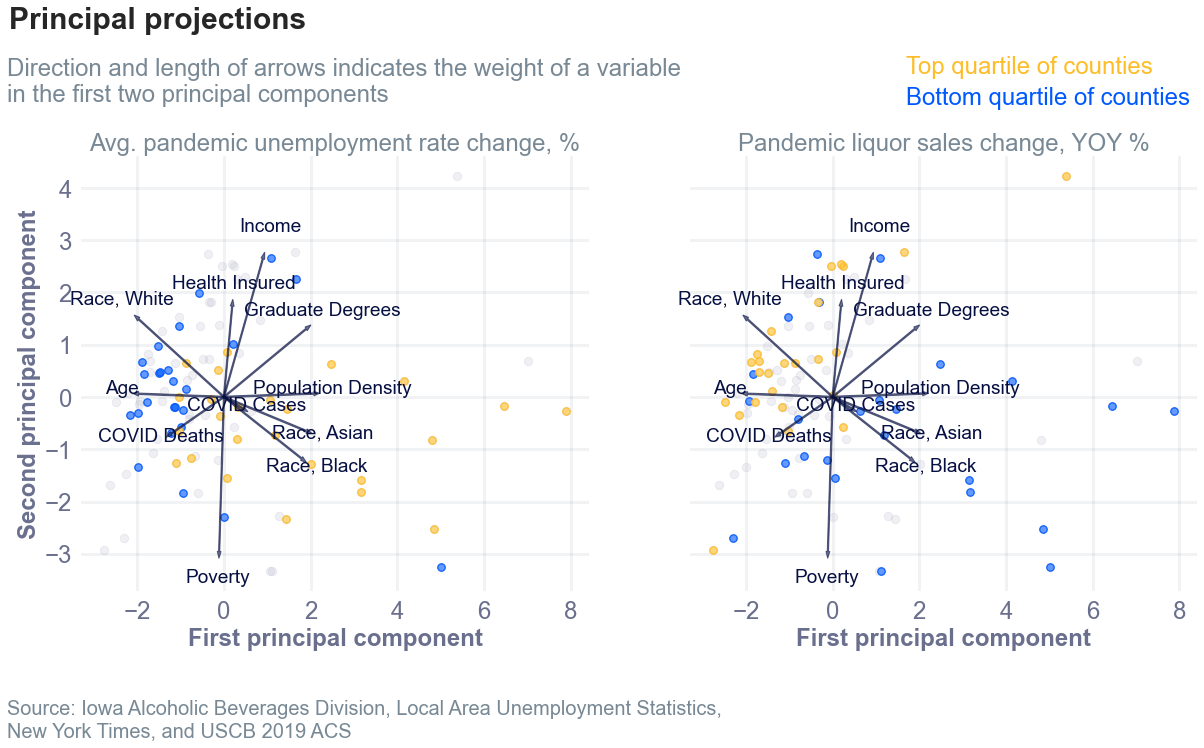

In [12]:
# Now, run PCA on all the other features and compare to change in unemployment and change in liquor sales using earlier color maps
feats = ['median_age',
         'perc_race_white',
         'perc_race_black',
         'perc_race_asian',
         'median_income',
         'perc_health_insurance',
         'perc_poverty',
         'perc_ed_gt_bach',
         'cases_per_capita',
         'deaths_per_capita',
         'log_pop_density']

df_temp = df_csy.loc[df_csy['window_size'] == 12][feats]
X = StandardScaler().fit_transform(df_temp.values)
pca = PCA()
X = pca.fit_transform(X)

df_temp = df_csy.loc[df_csy['window_size'] == 12][feats + ['unemployment_rate_diff', 'drinks_per_capita_per_month_perc']]
df_temp['pc1'] = X[:,0]
df_temp['pc2'] = X[:,1]

name_map = {
    'median_age': 'Age',
    'perc_race_white': 'Race, White',
    'perc_race_black': 'Race, Black',
    'perc_race_asian': 'Race, Asian',
    'median_income': 'Income',
    'perc_health_insurance': 'Health Insured',
    'perc_poverty': 'Poverty',
    'perc_ed_gt_bach': 'Graduate Degrees',
    'cases_per_capita': 'COVID Cases',
    'deaths_per_capita': 'COVID Deaths',
    'log_pop_density': 'Population Density'
}

fig, ax = plt.subplots(1, 2, figsize=(20,8), sharey=True)
col_names = ['Avg. pandemic unemployment rate change, %', 'Pandemic liquor sales change, YOY %']
for i, col in enumerate(['unemployment_rate_diff', 'drinks_per_capita_per_month_perc']):
    #cmap = get_continuous_cmap([COLORS[0], '#FFFFFF', COLORS[1]], [0, (df_temp[feat].quantile(0.75) - df_temp[feat].min()) / (df_temp[feat].max() - df_temp[feat].min()), 1.0])
    #im = ax[i].scatter(df_temp['pc1'], df_temp['pc2'], alpha=1.0, c=df_temp[col], cmap=cmap, s=70)
    ax[i].scatter(df_temp['pc1'], df_temp['pc2'], color='#b0b2c8', s=70, alpha=0.2)
    df_temp1 = df_temp.loc[df_temp[col] < df_temp[col].quantile(0.25)].copy()
    ax[i].scatter(df_temp1['pc1'], df_temp1['pc2'], facecolors='white', edgecolors=COLORS[0], alpha=0.8, s=55)
    ax[i].scatter(df_temp1['pc1'], df_temp1['pc2'], color=COLORS[0], alpha=0.6, s=55)
    df_temp1 = df_temp.loc[(df_temp[col] >= df_temp[col].quantile(0.25)) & (df_temp[col] < df_temp[col].quantile(0.75))].copy()
    df_temp1 = df_temp.loc[df_temp[col] >= df_temp[col].quantile(0.75)].copy()
    ax[i].scatter(df_temp1['pc1'], df_temp1['pc2'], facecolors='white', edgecolors=COLORS[1], alpha=0.8, s=55)
    ax[i].scatter(df_temp1['pc1'], df_temp1['pc2'], color=COLORS[1], alpha=0.6, s=55)
    ax[i].set_xlabel(xlabel='First principal component', color=DGREY, alpha=0.6, fontsize=FS_LABEL, fontweight='bold')
    ax[i].set_title(label=col_names[i], fontsize=FS_LABEL, color=GREY)
    if i == 0:
        ax[i].set_ylabel(ylabel='Second principal component', color=DGREY, alpha=0.6, fontsize=FS_LABEL, fontweight='bold')
    #plot_components
    comps = pca.components_
    comp_weights = list(zip(feats, comps[0,:], comps[1,:]))
    scaler = 5
    for feat, x, y in comp_weights:
        ax[i].arrow(0,0,scaler*x,scaler*y, color=DGREY, width=0.03, alpha=0.6)
        ax[i].annotate(name_map[feat], (1.2*scaler*x, 1.2*scaler*y), fontsize=FS_FOOTNOTE - 1, ha='center', color=DGREY, alpha=1.0)
    for i in range(2):
        for spine in ['top', 'right', 'left', 'bottom']:
            ax[i].spines[spine].set_visible(False)
    ax[i].grid(b=True, color=GREY, alpha=0.1, linewidth=3)
    ax[i].tick_params(colors=DGREY, labelsize=FS_LABEL, which='both')
    plt.setp(ax[i].get_xticklabels(), alpha=0.6)
    plt.setp(ax[i].get_yticklabels(), alpha=0.6)
fig.suptitle('Principal projections', x=0.075, y=1.14, ha='left', fontweight='bold', fontsize=FS_SUPTITLE)
ax[0].text(-5, 5.65, 'Direction and length of arrows indicates the weight of a variable\nin the first two principal components', fontsize=FS_CAPTION, color=GREY)
ax[0].text(-5, -6.5, 'Source: Iowa Alcoholic Beverages Division, Local Area Unemployment Statistics,\nNew York Times, and USCB 2019 ACS', fontdict={'fontsize': FS_FOOTNOTE}, color=GREY)
ax[1].text(1.7, 5.6, 'Bottom quartile of counties', color=COLORS[0], fontsize=FS_LABEL)
ax[1].text(1.7, 6.2, 'Top quartile of counties', color=COLORS[1], fontsize=FS_LABEL)
ax[0].tick_params(colors=DGREY, labelsize=FS_LABEL, which='both')
plt.setp(ax[0].get_xticklabels(), alpha=0.6)
plt.setp(ax[0].get_yticklabels(), alpha=0.6)
ax[0].grid(b=True, color=GREY, alpha=0.1, linewidth=3)

plt.show()

In [13]:
# Now, run the demeaned OLS
dfc = pd.read_csv(os.path.join(PDATA, 'df_county_series.csv'))
dfc = dfc.set_index('year_month')
dfc = dfc.fillna(0)

dfc['cases_per_1000'] = 1000 * dfc['cases'] / dfc['pop_total']
dfc['deaths_per_1000'] = 1000 * dfc['deaths'] / dfc['pop_total']

# Get month-over-month and year-over-year changes in liquor sales
dfc = dfc.sort_index()
dfc['n_drinks'] = (33.814 / 1.5) * dfc['n_liters']
dfc['n_drinks_per_capita'] = dfc['n_drinks'] / dfc['pop_gt18']
dfc['log_drinks_per_capita'] = np.log(dfc['n_drinks_per_capita'])
dfc['n_drinks_per_capita_mom'] = dfc.groupby('fips')['n_drinks_per_capita'].transform(lambda x: x.diff(1))
dfc['n_drinks_per_capita_yoy'] = dfc.groupby('fips')['n_drinks_per_capita'].transform(lambda x: x.diff(12))
dfc['n_drinks_per_capita_mom_pct'] = dfc.groupby('fips')['n_drinks_per_capita'].transform(lambda x: x.pct_change(1))
dfc['n_drinks_per_capita_yoy_pct'] = dfc.groupby('fips')['n_drinks_per_capita'].transform(lambda x: x.pct_change(12))
dfc['unemployment_rate_lead'] = dfc.groupby('fips')['unemployment_rate'].transform(lambda x: x.shift(-1))
dfc['cases_per_1000_lead'] = dfc.groupby('fips')['cases_per_1000'].transform(lambda x: x.shift(-1))
dfc['deaths_per_1000_lead'] = dfc.groupby('fips')['deaths_per_1000'].transform(lambda x: x.shift(-1))

In [14]:
# Get data for first 12 months of the pandemic
demean_feats = [
    'n_drinks_per_capita',
    'log_drinks_per_capita',
    'n_drinks_per_capita_yoy',
    'n_drinks_per_capita_yoy_pct',
    'unemployment_rate',
    'unemployment_rate_lead',
    'cases_per_1000',
    'deaths_per_1000',
    'cases_per_1000_lead',
    'deaths_per_1000_lead']
df_pan = dfc.loc['2020-03':'2021-02'].copy()
for feat in demean_feats:
    df_pan[f'{feat}_demean'] = df_pan.groupby('fips')[feat].transform(lambda x: x - x.mean())
df_pan.head()

,fips,n_liters,n_transactions,n_bottles,bottles_p_transaction,employment,unemployment,unemployment_rate,cases,deaths,pop_total,median_age,pop_gt18,pop_gt21,perc_gt21,perc_race_white,perc_race_black,perc_race_asian,perc_race_multi,median_income,perc_snap,perc_health_insurance,perc_poverty,perc_ed_gt_hs,perc_ed_gt_bach,perc_ed_gt_grad,county,county_num,area_sq_mi,lat,long,cases_per_1000,deaths_per_1000,n_drinks,n_drinks_per_capita,log_drinks_per_capita,n_drinks_per_capita_mom,n_drinks_per_capita_yoy,n_drinks_per_capita_mom_pct,n_drinks_per_capita_yoy_pct,unemployment_rate_lead,cases_per_1000_lead,deaths_per_1000_lead,n_drinks_per_capita_demean,log_drinks_per_capita_demean,n_drinks_per_capita_yoy_demean,n_drinks_per_capita_yoy_pct_demean,unemployment_rate_demean,unemployment_rate_lead_demean,cases_per_1000_demean,deaths_per_1000_demean,cases_per_1000_lead_demean,deaths_per_1000_lead_demean
year_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03,19001,2089.29,312,2263,7.253205,4090.0,130.0,3.2,1.0,0.0,7085,45.4,5566,5397,76.2,97.5,0.6,0.7,1.0,53363,11.7,95.6,5.8,94.2,18.5,4.2,adair,1,569.271,41.328528,-94.478164,0.141143,0.000000,47098.168040,8.461762,2.135557,1.269129,-4.460419,0.176448,-0.345175,9.0,0.000000,0.000000,-1.917068,-0.196032,-5.276986,-0.566552,-1.000000,4.808333,-9.338979,-0.329334,-9.832980,-0.376382
2020-03,19003,1075.42,186,1242,6.677419,2070.0,50.0,2.3,0.0,0.0,3670,47.3,2903,2813,76.6,98.6,0.1,0.2,0.2,49255,10.4,94.2,7.1,93.8,15.6,3.6,adams,2,423.433,41.021656,-94.696906,0.000000,0.000000,24242.834587,8.350959,2.122376,0.686453,4.672148,0.089563,1.270016,7.2,0.000000,0.000000,-1.130951,-0.120250,1.102207,-1.397568,-1.741667,3.100000,-7.198002,-0.090827,-7.266122,-0.090827
2020-03,19005,4465.83,606,4299,7.094059,6920.0,410.0,5.6,7.0,1.0,13813,44.4,10619,10254,74.2,96.5,1.3,0.6,1.0,52216,9.4,92.4,7.4,88.3,17.8,4.7,allamakee,3,639.044,43.274964,-91.382751,0.506769,0.072396,100671.717080,9.480339,2.249220,0.674709,-2.685335,0.076622,-0.220730,10.3,5.936437,0.144791,-4.651689,-0.353196,-4.511488,-0.385831,0.325000,5.000000,-7.915249,-0.205121,-2.980284,-0.144791
2020-03,19007,4367.99,603,5125,8.499171,5710.0,240.0,4.1,1.0,0.0,12452,45.7,9719,9308,74.8,97.0,0.7,0.5,1.5,40167,14.4,92.2,11.4,90.2,16.3,4.8,appanoose,4,497.289,40.744249,-92.873065,0.080308,0.000000,98466.142573,10.131304,2.315630,-1.759808,-6.244799,-0.147994,-0.381336,10.5,0.080308,0.160617,-3.649097,-0.286192,-5.966384,-0.379599,-1.308333,5.091667,-8.124532,-0.314541,-8.305225,-0.153924
2020-03,19009,1510.44,255,1505,5.901961,2950.0,90.0,3.0,1.0,0.0,5571,48.1,4425,4262,76.5,96.9,0.2,0.3,2.5,52055,8.3,94.8,8.6,89.5,17.1,5.1,audubon,5,442.961,41.679178,-94.904312,0.179501,0.000000,34049.345440,7.694767,2.040541,2.103931,1.572689,0.376318,0.256888,6.5,0.000000,0.000000,-0.601660,-0.064090,-0.195264,-0.029561,-0.541667,2.933333,-6.791121,-0.134626,-7.284748,-0.134626


In [15]:
dm_formula = """n_drinks_per_capita_demean ~ 
                unemployment_rate_demean"""

ols = sm.OLS.from_formula(dm_formula, data=df_pan).fit(cov_type='cluster', cov_kwds={'groups': df_pan['fips']})

ols.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     n_drinks_per_capita_demean   R-squared:                       0.006
Model:                                    OLS   Adj. R-squared:                  0.005
Method:                         Least Squares   F-statistic:                     13.83
Date:                        Tue, 25 May 2021   Prob (F-statistic):           0.000334
Time:                                00:24:46   Log-Likelihood:                -3017.2
No. Observations:                        1187   AIC:                             6038.
Df Residuals:                            1185   BIC:                             6049.
Df Model:                                   1                                         
Covariance Type:                      cluster                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  3.01e-16   1.55e-16      1.940      0.052   -3.08e-18    6.05e-16
unemployment_rate_demean     0.1174      0.032      3.718      0.000       0.055       0.179
==============================================================================
Omnibus:                      401.565   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8046.688
Skew:                           1.052   Prob(JB):                         0.00
Kurtosis:                      15.580   Cond. No.                         2.02
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [16]:
dm_formula = """n_drinks_per_capita_demean ~ 
                unemployment_rate_demean +
                cases_per_1000_demean +
                deaths_per_1000_demean"""

ols = sm.OLS.from_formula(dm_formula, data=df_pan).fit(cov_type='cluster', cov_kwds={'groups': df_pan['fips']})

ols.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     n_drinks_per_capita_demean   R-squared:                       0.008
Model:                                    OLS   Adj. R-squared:                  0.006
Method:                         Least Squares   F-statistic:                     6.199
Date:                        Tue, 25 May 2021   Prob (F-statistic):           0.000670
Time:                                00:24:46   Log-Likelihood:                -3015.8
No. Observations:                        1187   AIC:                             6040.
Df Residuals:                            1183   BIC:                             6060.
Df Model:                                   3                                         
Covariance Type:                      cluster                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  3.01e-16   1.56e-16      1.929      0.054    -4.8e-18    6.07e-16
unemployment_rate_demean     0.1124      0.043      2.618      0.009       0.028       0.196
cases_per_1000_demean       -0.0099      0.010     -0.952      0.341      -0.030       0.010
deaths_per_1000_demean       0.5303      0.298      1.783      0.075      -0.053       1.113
==============================================================================
Omnibus:                      400.053   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8025.828
Skew:                           1.046   Prob(JB):                         0.00
Kurtosis:                      15.566   Cond. No.                         36.7
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""